In [215]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import OneHotEncoder
import importlib


# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *

In [214]:
import auxFuns.modelling 
importlib.reload(auxFuns.modelling )

<module 'auxFuns.modelling' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\modelling.py'>

# 1. Exploration of ML algorithms and visualization of their decision boundaries
- Fitting various ML algorithms (linear, tree-based, distance-based)
- Interpretability and explanation

In [4]:
# Load data sets under study (VSCode)
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_phase1_df = pd.read_csv(raw_datasets_path + '/rsv_predictors_df_phase1_v3.csv')
rsv_predictors_phase1_daysDedup_df = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup.csv',low_memory=False)

# Load data sets under study (GColab)
# rsv_predictors_phase1_df = pd.read_csv('/content/rsv_predictors_df_phase1_v3.csv')
# rsv_predictors_phase1_daysDedup_df = pd.read_csv('/content/rsv_predictors_phase1_daysDedup.csv', low_memory=False)

In [63]:
rsv_predictors_phase1_df = make_it_categorical(rsv_predictors_phase1_df)
rsv_predictors_phase1_daysDedup_df = make_it_categorical(rsv_predictors_phase1_daysDedup_df)

rsv_predictors_phase1_df.shape, rsv_predictors_phase1_daysDedup_df.shape

# Extract a reduced sample of the data for modelling
sample_size = 10000
sample_rsv_df = rsv_predictors_phase1_df.sample(n = sample_size)
sample_dedup_rsv_df = rsv_predictors_phase1_daysDedup_df.sample(n = sample_size)

# sample_rsv_df = rsv_predictors_phase1_df.copy()
# sample_dedup_rsv_df = rsv_predictors_phase1_daysDedup_df.copy()

In [64]:
sample_rsv_df['RSV_test_result'].value_counts(), sample_dedup_rsv_df['RSV_test_result'].value_counts()

(RSV_test_result
 Negative    9694
 Positive     306
 Name: count, dtype: int64,
 RSV_test_result
 Negative    9712
 Positive     288
 Name: count, dtype: int64)

In [213]:
X_train['sex'].unique()

['M', 'F', 'Unknown']
Categories (3, object): ['F', 'M', 'Unknown']

In [102]:
# 1. Transform the data and prepare it for modelling
df1 = sample_dedup_rsv_df.drop(
    ['patient_id', 'index_date', 'tendency_to_positivity', 'n_encounters'], axis = 1)

X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_rsv(df1, 
                                                                          input_test_size = 0.2, random_seed = 42
                                                                          )

In [221]:
# Transform the data using resampling: SMOTE-NC
X_train_transformed_smote, y_train_smote, X_test_transformed_smote, y_test_smote, preprocessor_rsv = preprocess_and_resample_rsv(
    df1, input_test_size = 0.2, random_seed = 42, resampling_technique = 'smotenc', ratio_maj_min = 0.8)

Resampling method chosen:

SMOTE-sampling


In [224]:
X_train_transformed_smote.shape, y_train_smote.value_counts()

((13986, 83),
 RSV_test_result
 Negative    7770
 Positive    6216
 Name: count, dtype: int64)

In [104]:
# 2. Fit the model, specyfing a) model class b) hyperparameter_grid, target_scorer, number of cross-validation folds
model_class = RandomForestClassifier()
param_grid = {
    'n_estimators': [7, 14],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 4]
}
target_scorer = make_scorer(f1_score, average='macro')
n_cv_folds = 10

model1 = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train_transformed, y_train = y_train)


Training model ... RandomForestClassifier()
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 14}
Best training f1-score:  0.6702034250145144


Optimal threshold: 0.2
Optimal f1: 0.3870967741935484


AUC Score: 0.6479326875062419
Precision / Positive predictive value: 0.5806451612903226
Specificity: 0.9932920536635707
Recall / sensitivity: 0.2903225806451613
Negative predictive value: 0.9776536312849162
Accuracy: 0.9715
F-1: 0.3870967741935484


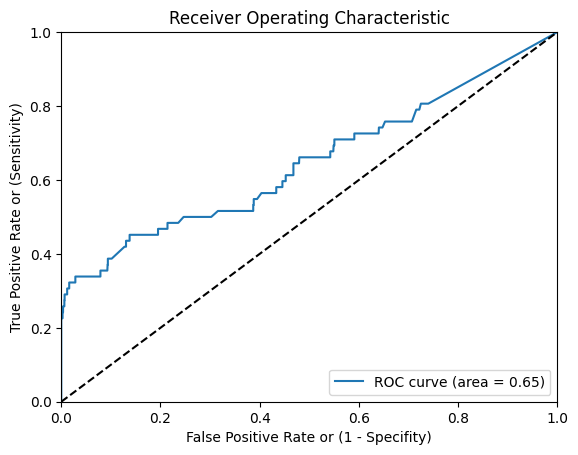

In [164]:
# 4. Obtain optimal threshold and evaluate the resulting model
optimal_threshold = find_optimal_moving_threshold(model = model1, X_test = X_test_transformed, y_test = y_test)


__,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = True)

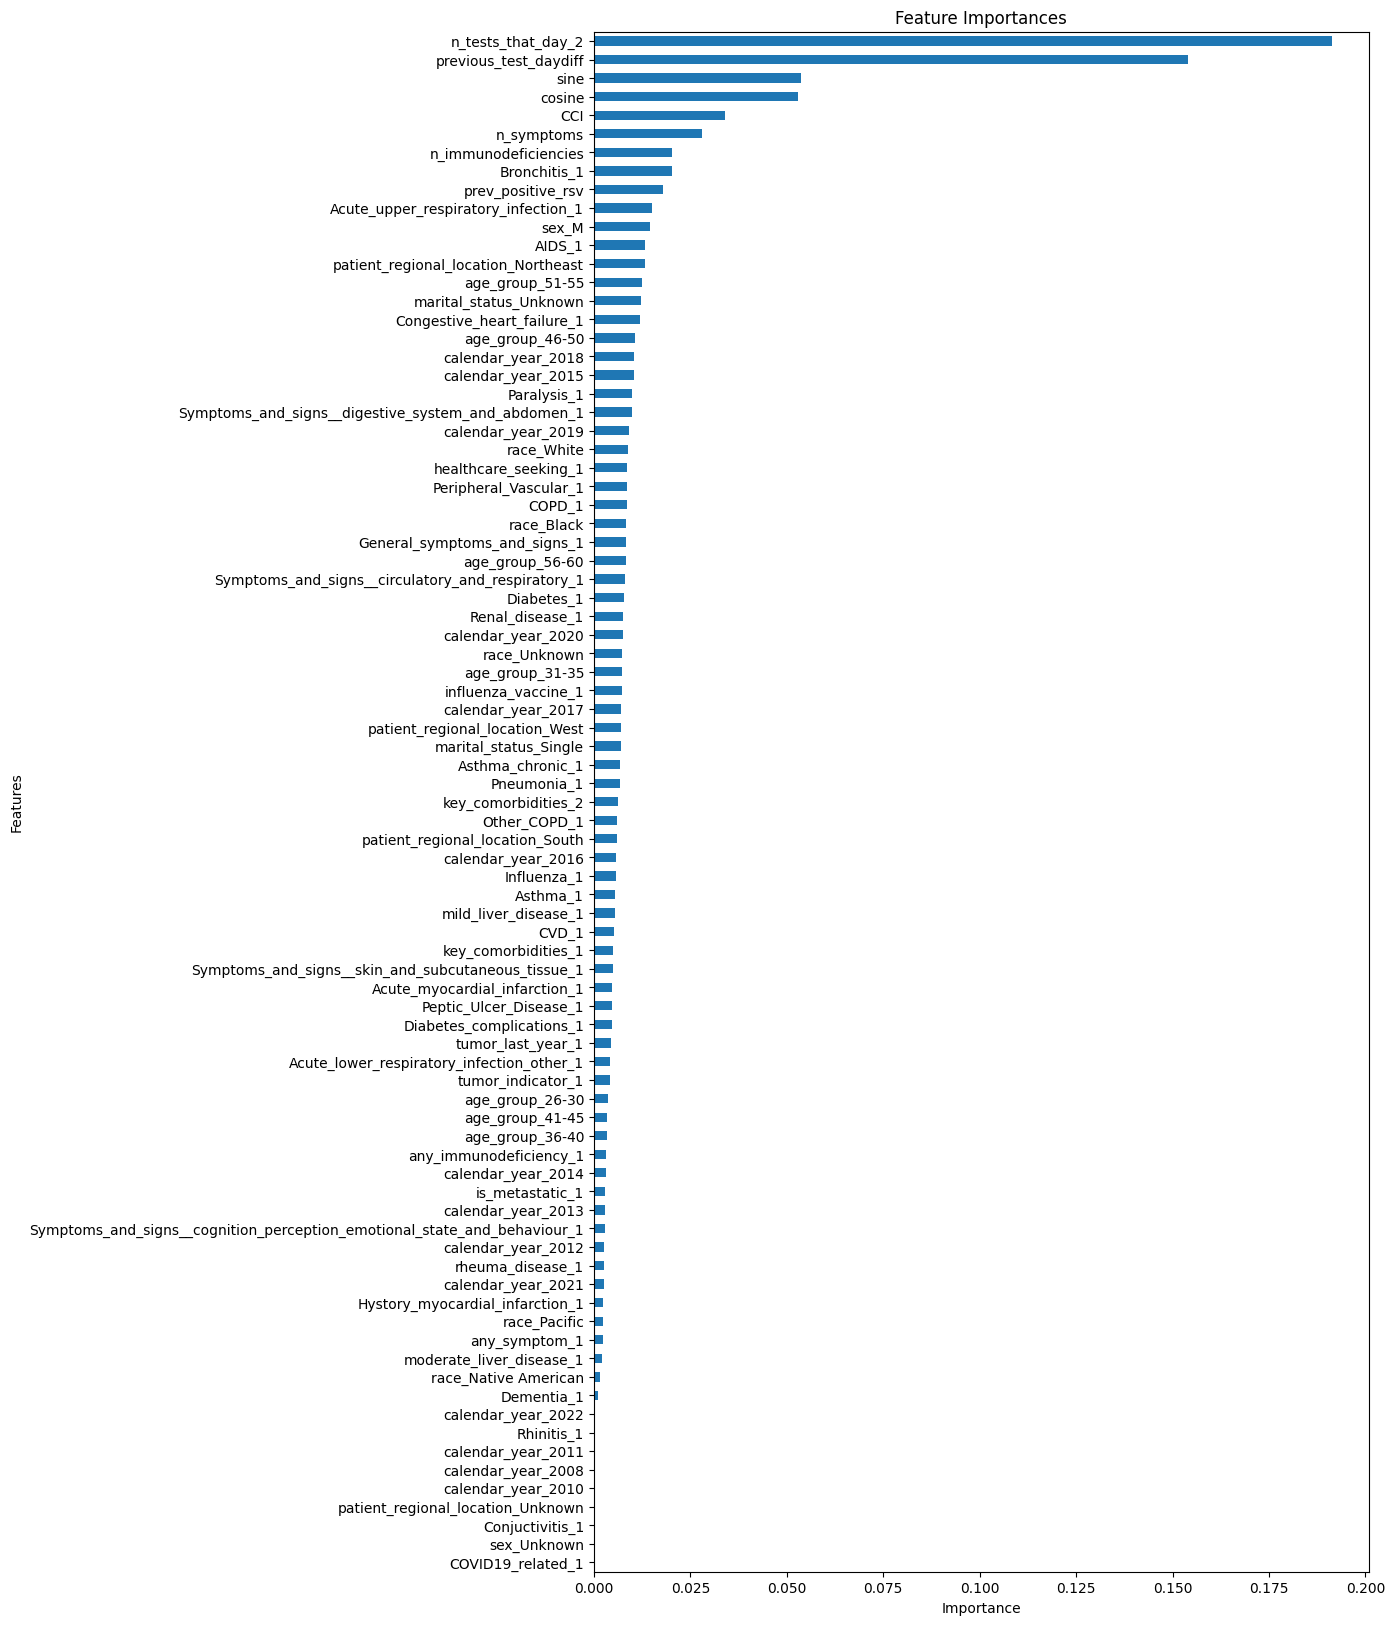

In [106]:
# Observe the feature importances plot to detect potential inconsistencies
plot_feature_importance_rf_rsv(preprocessor_rsv, trained_model = model1)